In [1]:
import numpy as np
from matplotlib import pyplot as plt
import functions as ut

In [39]:
N = 10000
K = 10

In [49]:
# Exercise 1 part 1

def load(filename):
    X=ut.LoadBatch(filename)
    out = {}
    out["labels"] = X[b"labels"]
    tmp = np.zeros((K,N))
    for i in range(N):
        tmp[X[b"labels"][i]][i]=1
    out["hot"] = tmp
    out["data"] = X[b"data"].T.astype(float)
    return out

In [50]:
A=load("data_batch_1")

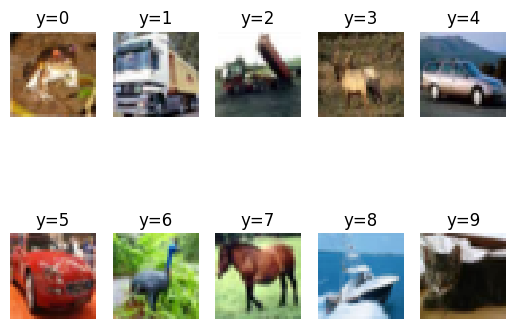

In [51]:
ut.montage(A["data"].T)

In [65]:
# Exercise 1 part 2

def transform(data):
    meanX = np.mean(data,axis=0)
    normed = data - meanX
    stdX = np.std(normed,axis=0)
    return normed / stdX

In [66]:
ndata = transform(A["data"])

In [68]:
np.mean(ndata, axis=0)

array([ 0.00000000e+00,  1.38777878e-16, -1.11022302e-16, ...,
        7.40148683e-17, -9.25185854e-17, -9.25185854e-17])

In [69]:
np.std(ndata, axis = 0)

array([1., 1., 1., ..., 1., 1., 1.])